# Projet statistique descriptive 

Projet de statistiques descriptives MACS3, dans le cadre du cours de Jérôme Lacaille.

_Version 1.0 [03/12/2023] HUSSON Félix_





In [1]:
%reload_ext autoreload
%autoreload 2

# module
import sys
sys.path.append("../")
from src import * 

# chemin vers la donnee 
data_dir = 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive/'
filelist = glob.glob(data_dir + '*.h5')
filelist

['C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03_dask.h5']

In [ ]:
**Importation des modules pour l'analyse**

In [2]:
from tabata import Opset
#première visualisation brut de la données 

# Première visualisation brut de la données 
La visualisation des graphes nous à permis dans un premier temps de constater des anomalies dans les données et de supprimer ces données pour la suite de nos analyse.En effet ces données dites anormales représentent des mesures ou l'avions n'à pas décollé (sûrement des tests au sols) donc il est légitimes de les supprimer quand on s'intéresse aux comportements de l'avion en vol.

In [3]:
df_opset1=Opset('C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01.h5')
df_opset2=Opset('C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02.h5')
df_opset3=Opset('C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03.h5')

In [ ]:
df_opset1.plot()

In [ ]:
df_opset2.plot()

In [ ]:
df_opset3.plot()

Curiosité: On remarque que fréquament pendant la croisière il y un petit creux très bref de 500 pied, je pense qu'il s'agit d'une allucination du capteur de l'altitude à creuser...

## Creation d'une fonction sur les dataframes pour éliminer les records anormaux
On utilise l'avantage de Dask qui permet de paralléliser sur les dataframes.
Le but de la fonction eliminate_records() est de vérifier la différence entre l'altitude minimum et maximum est d'au plus 15000 ft si c'est le cas alors elle renvoit False et True sinon.



In [7]:
def eliminate_records(df):
    
    alt_min=df['ALT [ft]'].min()
    alt_max=df['ALT [ft]'].max()
    alt_range=alt_max-alt_min
    bol=False
    
    if alt_range<15000:
        bol=True
    return bol
    
    

In [8]:
#on cree notre dataframe avec DASK
ddf1 = lire_hdf_dask(filelist[0], repertoire= data_dir)
#on récupère une liste de booleen où chaque composante fait reférance à une partition 
I = ddf1.map_partitions(lambda df: eliminate_records(df)).compute()
#on sélectione dans un nouveau dataframe les partitions qui ne sont pas anormales 
DDF1=ddf1.partitions[I==False]
# on normalise toute les données excepté les variables booleen 
ddf_norm1 = DDF1.map_partitions(lambda df : normalize(df))

ddf2 = lire_hdf_dask(filelist[2], repertoire= data_dir)
I = ddf2.map_partitions(lambda df: eliminate_records(df)).compute()
DDF2=ddf2.partitions[I==False]
ddf_norm2 = DDF2.map_partitions(lambda df : normalize(df))

ddf3 = lire_hdf_dask(filelist[3], repertoire= data_dir)
I = ddf3.map_partitions(lambda df: eliminate_records(df)).compute()
DDF3=ddf3.partitions[I==False]
ddf_norm3 = DDF3.map_partitions(lambda df : normalize(df))

In [9]:
import seaborn as sns


# Etude sur le vol en entier à l'aide de corelation et de l'analyse en composante principale

On reprends ce qu'on a vu en TP sur d'autre donnée et on e

In [81]:

# calculate the correlation matrix
df_cor=ddf_norm1.partitions[0].compute()

A=df_cor.drop(['EGT_1','FMV_1','HPTACC_1','N1_1','N2_1','P0_1','PS3_1','PT2_1','P_OIL_1','Q_1','T1_1','T2_1','T3_1','T5_1','TBV_1','TCASE_1','TLA_1','T_OIL_1','VBV_1','VIB_AN1_1','VIB_AN2_1','VIB_BN1_1','VIB_BN2_1','VSV_1'],axis=1)
#B=A.drop(['EGT_1','FMV_1','HPTACC_1','N1_1','P0_1','PS3_1','PT2_1','P_OIL_1','Q_1','T1_1','T2_1','T3_1','T5_1','TBV_1','TCASE_1','TLA_1','T_OIL_1','VBV_1','VIB_AN1_1','VIB_AN2_1','VIB_BN1_1','VIB_BN2_1','VSV_1'],axis=1)
corr = A.corr()


<Axes: >

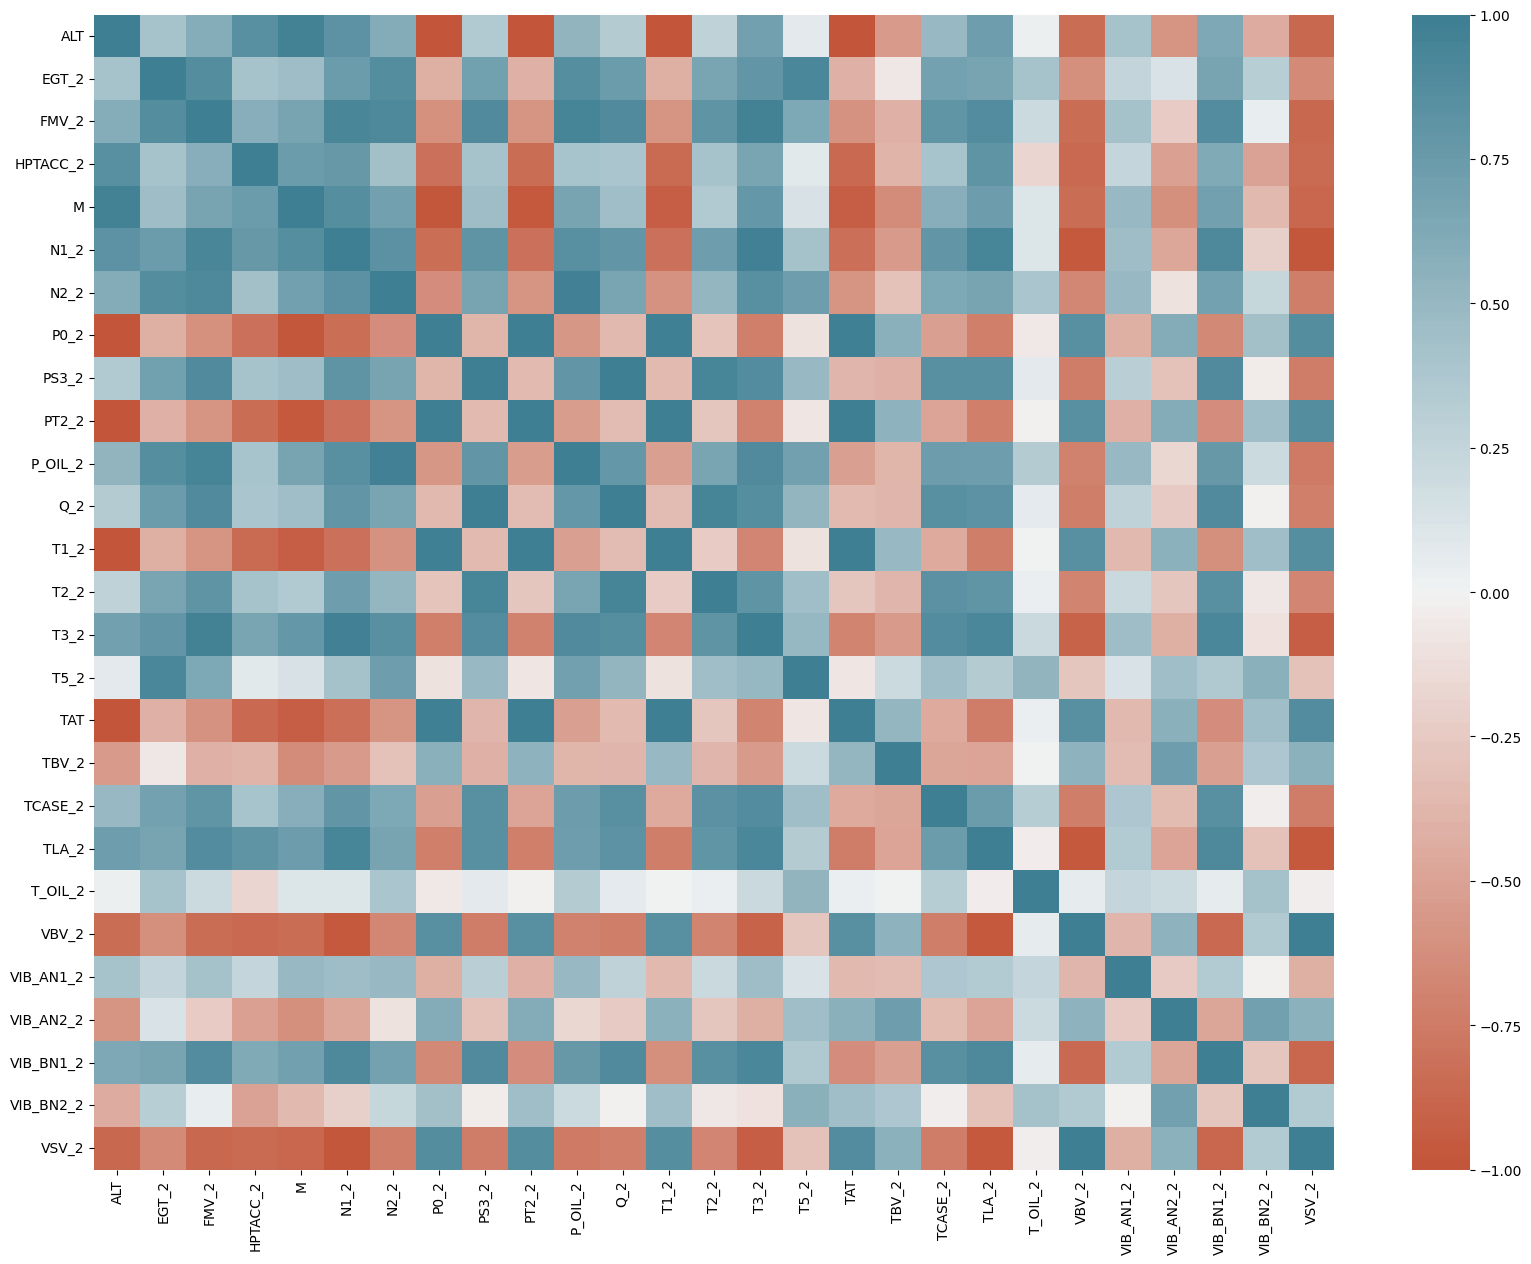

In [82]:
# plot the heatmap
fig = plt.figure(figsize=(20,15))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=False, fmt='.2f', vmin=-1, vmax=1, center=0, 
        cmap=sns.diverging_palette(20, 220, n=200))


In [91]:
df_cor2=ddf_norm1.partitions[1].compute()
C=df_cor2.drop(['EGT_1','FMV_1','HPTACC_1','N1_1','N2_1','P0_1','PS3_1','PT2_1','P_OIL_1','Q_1','T1_1','T2_1','T3_1','T5_1','TBV_1','TCASE_1','TLA_1','T_OIL_1','VBV_1','VIB_AN1_1','VIB_AN2_1','VIB_BN1_1','VIB_BN2_1','VSV_1'],axis=1)
corr2 = C.corr()
COR=(corr-corr2) # attention la différence de matrice de corelation n'est pas une matrice de corelation 

On mesure la difference de correlation entre deux vols ainsi les variables qui sont corrélé entre elle par le vol de la même manière sont nulle. Autrement dit les variables qui apparaisse en coleur sont celle qui on changé de coefficient de correlation entre 2 vols. Quand on reagarde de plus près on vois que les variables lié aux vibration ont celles dont les corrélation change le plus entre les vols.

Ici on fait la différence de correlation entre deux vols qui ce suivent et d'un même avion.

<Axes: >

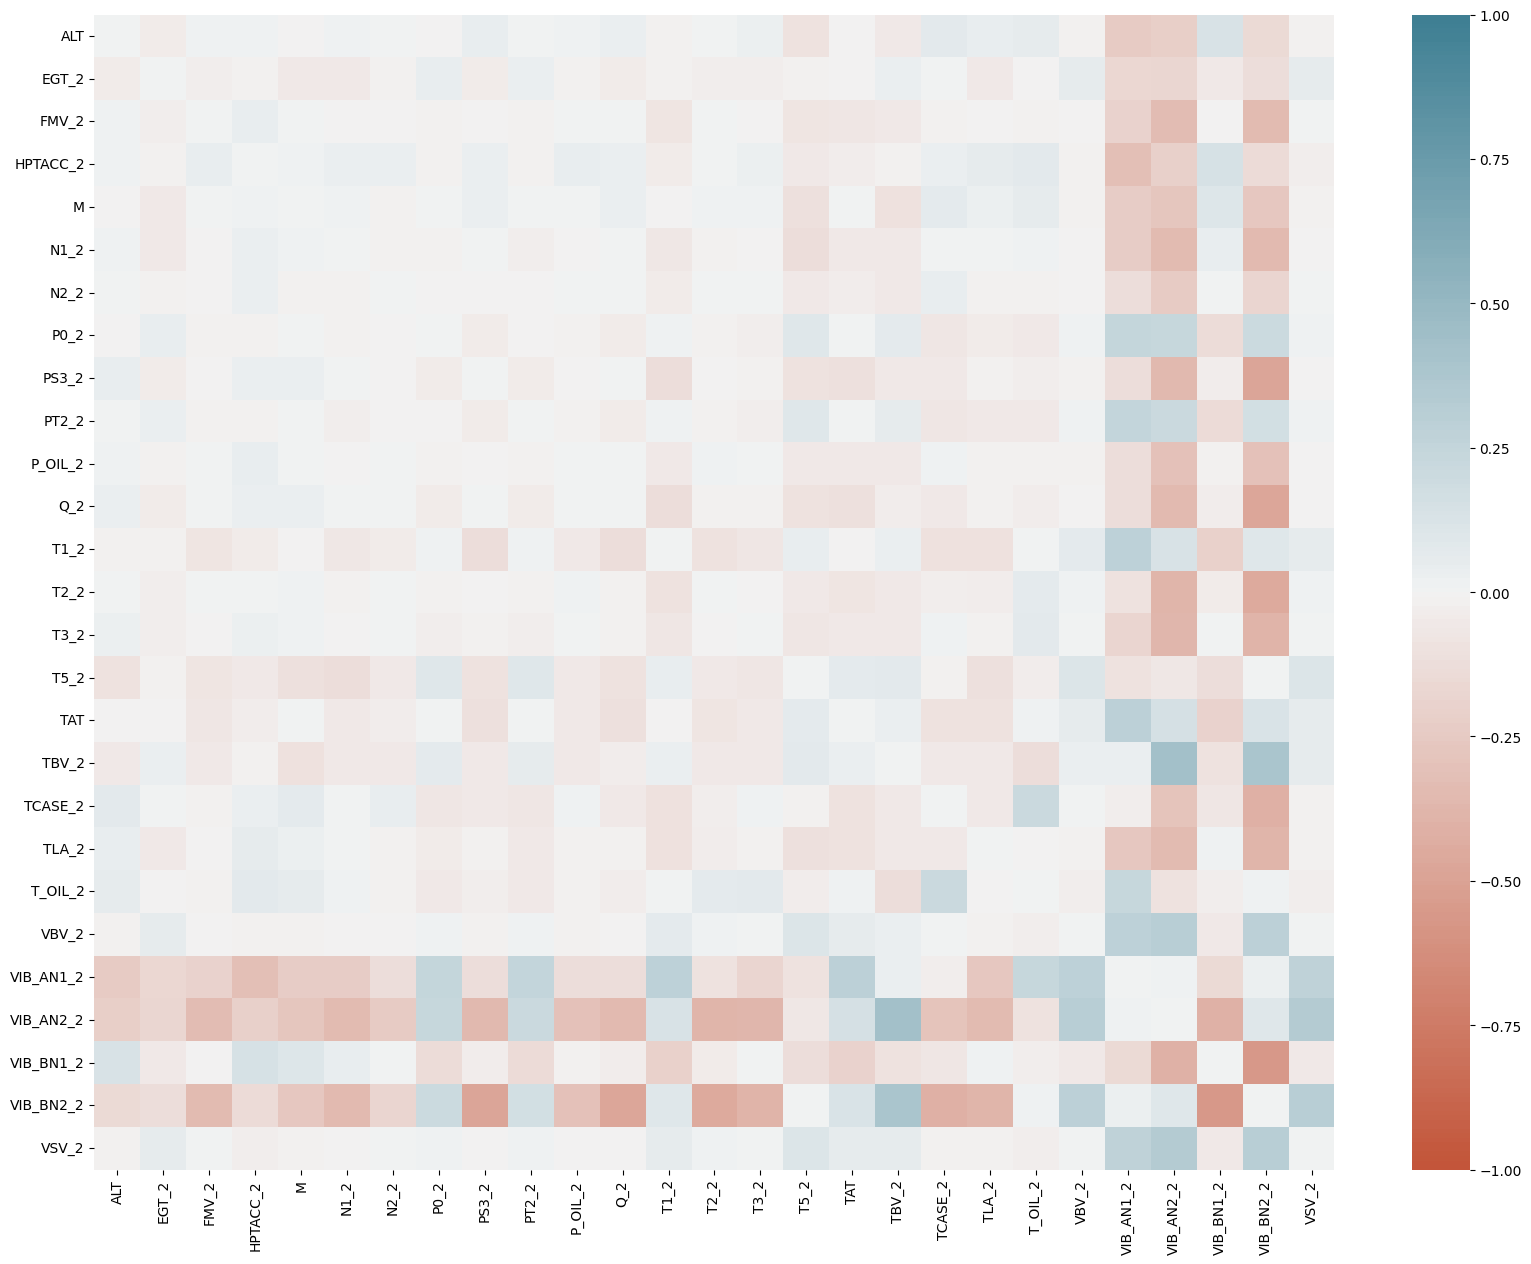

In [93]:
fig = plt.figure(figsize=(20,15))

sns.heatmap(COR, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=False, fmt='.2f', vmin=-1, vmax=1, center=0, 
        cmap=sns.diverging_palette(20, 220, n=200))


On remarque pas de grande difference entre le matrice de corelation, la plus grande différence se fait sur les variables lié à la vibration du moteur 

**import des librairies**

In [14]:
from sklearn.decomposition import PCA

In [15]:
from sklearn.preprocessing import StandardScaler

**Calcul de l'ACP**

In [54]:
DDF=ddf_norm1.partitions[100].compute()


vol_pca = PCA(n_components=2).fit(DDF)
vol_proj = vol_pca.transform(DDF)

Part de variance expliquée par CP :
[0.59742314 0.18184104]
Pourcentage de variance totale expliquée :
77.9264181537262 %


Text(0.5, 1.0, 'Projection PCA du vol')

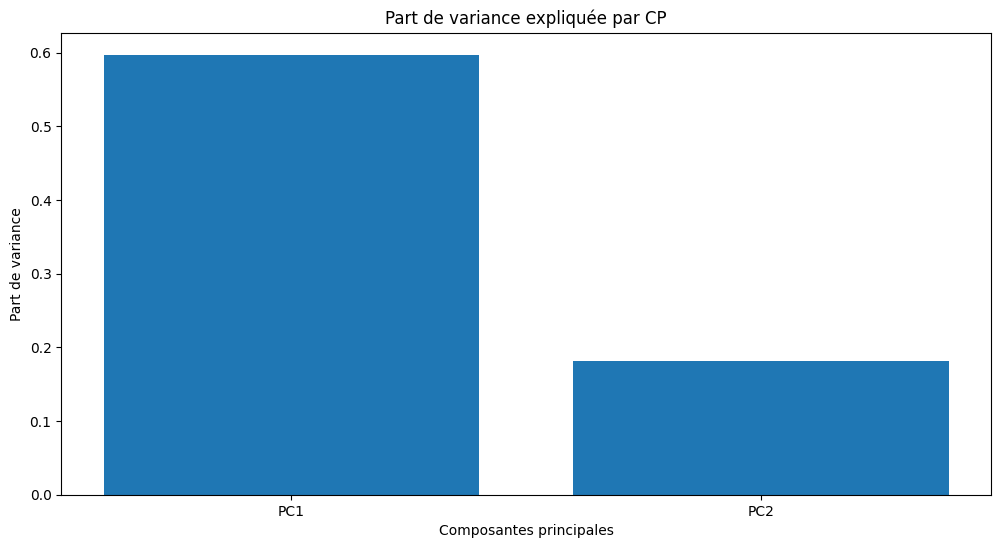

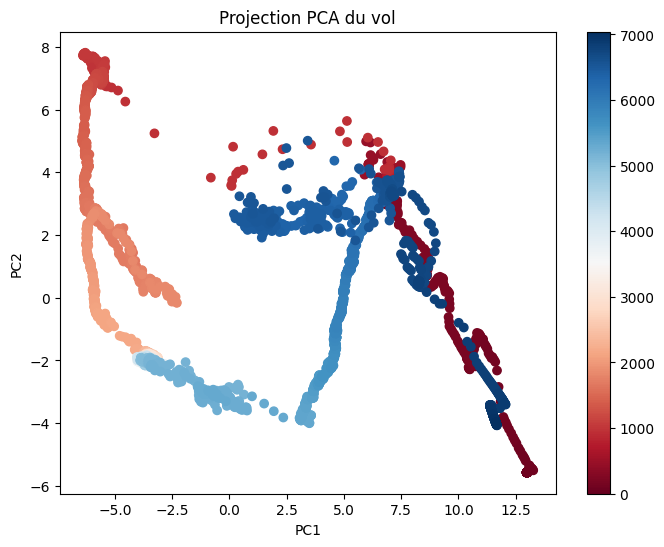

In [96]:
print('Part de variance expliquée par CP :')
print(vol_pca.explained_variance_ratio_)
print('Pourcentage de variance totale expliquée :')
print(vol_pca.explained_variance_ratio_.sum()*100, '%')

plt.figure(figsize=(12,6))
plt.bar(np.arange(vol_pca.n_components), vol_pca.explained_variance_ratio_, tick_label=['PC'+str(i+1) for i in range(vol_pca.n_components)], log=False)
plt.title('Part de variance expliquée par CP');
plt.ylabel('Part de variance')
plt.xlabel('Composantes principales');




plt.figure(figsize=(8,6))
plt.scatter(vol_proj[:, 0], vol_proj[:, 1], cmap='RdBu', c=np.arange(vol_proj.shape[0]))
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection PCA du vol')

On constate d'après ce graphe qu'il a deux directions privilégiés qui explique 80% de la variance, on regarde la projection de celles-ci sur ces deux direction avec une color bar qui dépends du temps écoulé. On remarque quelque chose de puissant c'est que pendant le vol la projection des données suivant les directions pricipales varie mais de façon "CONTINUE" autrement dit les projections des données sont proche des unes des autre si elles sont proche dans le temps.

In [20]:
def deriv_glissante(df):
    
    #on cree une fonction qui prend un data frame qui l'augment de la valeur dy et qui renvoit  un nouveau dataframe contenant que le monté 
    #ATTENTION LA FONCTION PRENDS EN ENTREE DES DONNEES NORMALISEE
    
    dy=np.zeros(len(df))
    
    #on fait une moyenne glissante pour éviter d'être sensible aux bruit. En effet pour le cacul de dérivée le bruit 
    #fausse trés rapidement les données
    y = df['ALT'].rolling(window = 20).mean()
    I = range(y.index[0], y.index[-1],20)
    #calcul de la derivée
    dy[0:len(I)-1] = y[I[1:]].values- y[I[:-1]].values
    #creation d'une nouvelle colonne dans le dataframe vitesse de mont en ft/s
    df['dy']=dy
    #on selectionne le dataframe où les dérivées sont plus grande que 0.01 (la montée)
    df_monte=df[df['dy']>0.01]
    I4=np.zeros(len(df_monte))
    #on verifie qu' avec un shift des données on retombe bien sur les mêmes indices cela permet d'éviter 
    # de prendre en compte des valeurs qui ne serait pas dans la phase de la montée 
    #Attention cette façon de faire est lié aux cas d'un vol d'avion (l'hypothèse admise est que l'avion ne monte qu'une fois)
    #Et s'il existe plus de 6 données anormale consécutives alors elles seront prise en compte 
    
    I4[5:]=df_monte.index[5:]==(df_monte.index+5)[:-5]
    I4[:5]=1
    df_monte2=df_monte[I4==1]

    #je rajoute une nouvelle fois la dérivé cette fois non moyennée pour garder la correspondance entre les variable i.e a un instant t la derivé et les autres mesures sont aussi prise à l'instant t
    vy= np.empty(len(df))
    y2 = df['ALT'].values
    vy[:-1] = y2[1:]-y2[:-1]
    vy[-1]=0
    df['vy']=vy
    
    


    return df_monte2

**mise en place du dataframe de la montée**

In [119]:
df12=ddf_norm1.partitions[100].compute()

df_monte2=deriv_glissante(df12)


#plt.plot(df12['EGT_1'][I_monte])


#duree de la monte
duree=len(df_monte2)*20
#Indice monte
I_monte=df_monte2.index*20
#calcul de l'egt max pour chaque moteur pendant la monté
EGT_max_monte1=df12['EGT_1'][I_monte].max()
EGT_max_monte2=df12['EGT_2'][I_monte].max()
EGT_max_monte=max(EGT_max_monte1,EGT_max_monte2)

#on sélectionne un dataframe de la monté
df_CORR=df12.iloc[I_monte]
#creation de coef corelation
CORR=df_CORR.corr()
corelation_EGT_vy=CORR['vy']['EGT_1']
corelation_EGT_vy

0.5364554499377653

### Calcul de PCA sur le dataframe de la monte 
On cherche à étudier l'ACP sur le dataframe de la montee 

In [99]:



vol_pca2 = PCA(n_components=2).fit(df_CORR)
vol_proj2 = vol_pca2.transform(df_CORR)

Part de variance expliquée par CP :
[0.77452786 0.13392083]
Pourcentage de variance totale expliquée :
90.84486847383877 %


Text(0.5, 1.0, 'Projection PCA du vol')

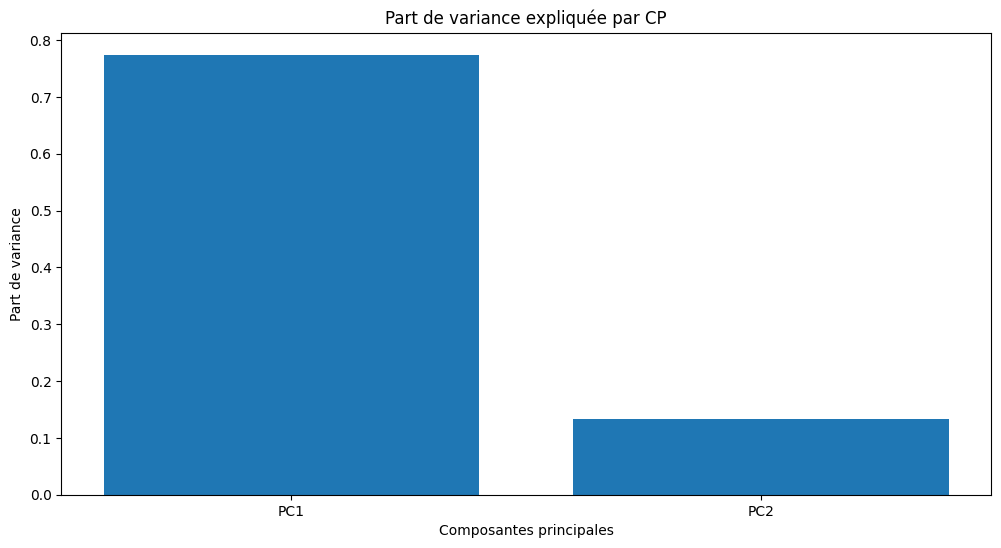

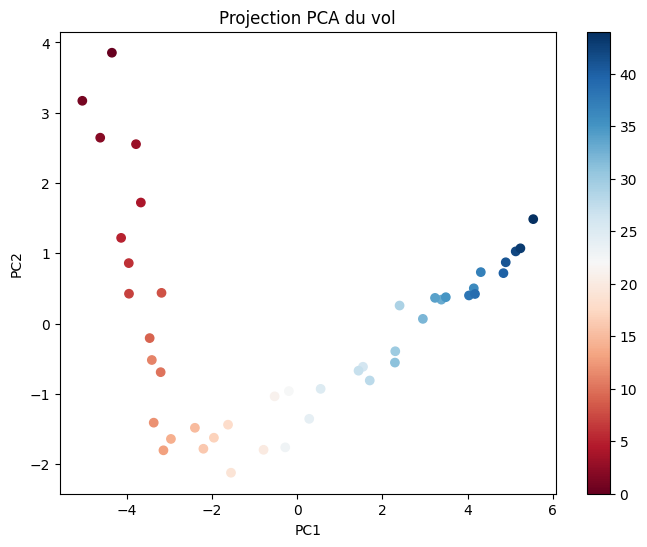

In [97]:
print('Part de variance expliquée par CP :')
print(vol_pca2.explained_variance_ratio_)
print('Pourcentage de variance totale expliquée :')
print(vol_pca2.explained_variance_ratio_.sum()*100, '%')

plt.figure(figsize=(12,6))
plt.bar(np.arange(vol_pca2.n_components), vol_pca2.explained_variance_ratio_, tick_label=['PC'+str(i+1) for i in range(vol_pca2.n_components)], log=False)
plt.title('Part de variance expliquée par CP');
plt.ylabel('Part de variance')
plt.xlabel('Composantes principales');



plt.figure(figsize=(8,6))
plt.scatter(vol_proj2[:, 0], vol_proj2[:, 1], cmap='RdBu', c=np.arange(vol_proj2.shape[0]))
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection PCA du vol')

Lorsqu'on compare entre l'analyse ACP de la montée et de l'entièreté du vol on remarue que la part de la varience expliué passe de 80% à 90% et que le caractère "CONTINUE" est conservé. Une précision qu'on peut ajouter est que sur un dataframe plus petit la part de variance expliqué peut je pense plus facilement augmenter. Deplus sur un dataframe différents les directions pricipales sont évidaments différentes aussi.

**Etude de la variation du coefficient de corelation de la vitese en fonction de L'EGT aux cours des vols**

In [115]:
COR_EGT_vy=[]
I=[]
for i in range (0,990,5):
    I.append(i)
    df13=ddf_norm1.partitions[i].compute()
    df_monte3=deriv_glissante(df13)
    I_monte3=df_monte3.index*20
    #creation dataframe montée
    df_CORR=df13.iloc[I_monte3]
    #calcul des corélation
    CORR=df_CORR.corr()
    COR_EGT_vy.append(CORR['vy']['EGT_2'])
    

**Calcul de la médiane du coefficient et représentation du coefficient de corélation en fonction du temps**

Médiane du coefficient de corrélation de la vitesse et de l'EGT :
0.5511865040571315


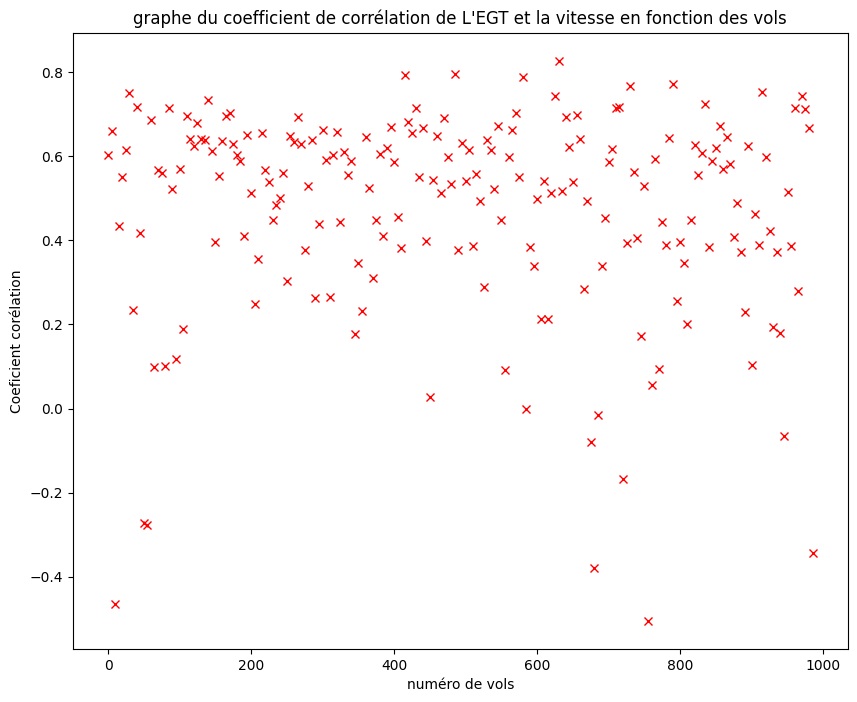

In [116]:
print("Médiane du coefficient de corrélation de la vitesse et de l'EGT :")
print(np.median(COR_EGT_vy))


plt.figure(figsize=(10,8))
plt.plot(I,COR_EGT_vy,'rx')

plt.xlabel('numéro de vols')
plt.ylabel('Coeficient corélation')
plt.title("graphe du coefficient de corrélation de L'EGT et la vitesse en fonction des vols");

On remarque assez facilement que le coefficient peut varié mais il se situe aux alentour de 0.55 ce qui implique une corrélation positive de la vitesse et de l'EGT. Ce résultat était prévisible mais on arrive à prouver la corrélation sans toute fois trouver clairement la dépendance entre ces deux données Cf EGT_felix